<a href="https://colab.research.google.com/github/FilippMaksimov/SPbSU.Series/blob/main/Maksimov_F_Series_Lab02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [ ]:
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [ ]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

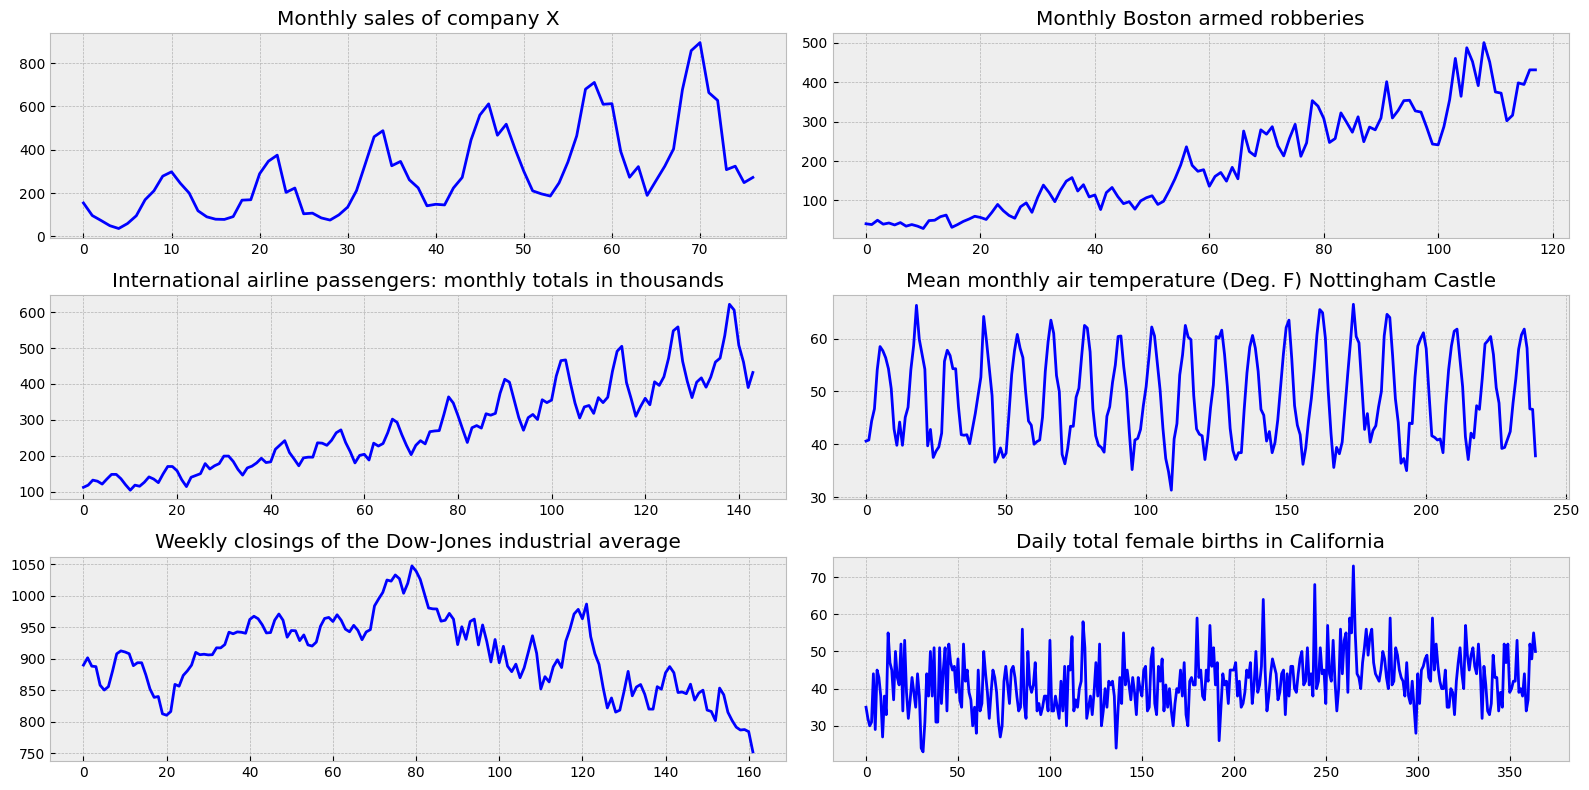

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

Для выполнения задания из стационарных рядов возьмем ряд "Daily total female births in California" и ряд "International airline passengers: monthly totals in thousands" из числа не стационарных

In [ ]:
def train_test_split(y, train_size=0.75):
  return y[:int(len(y) * train_size)], y[int(len(y) * train_size):]

In [ ]:
y_train, y_test = train_test_split(female_births["Count"])

In [ ]:
#Для стационарного ряда попробуем применить Метод взвешенного скользящего среднего
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(window=n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [ ]:
wma = weighted_moving_average(female_births["Count"], 4, [1, 1, 2, 3])

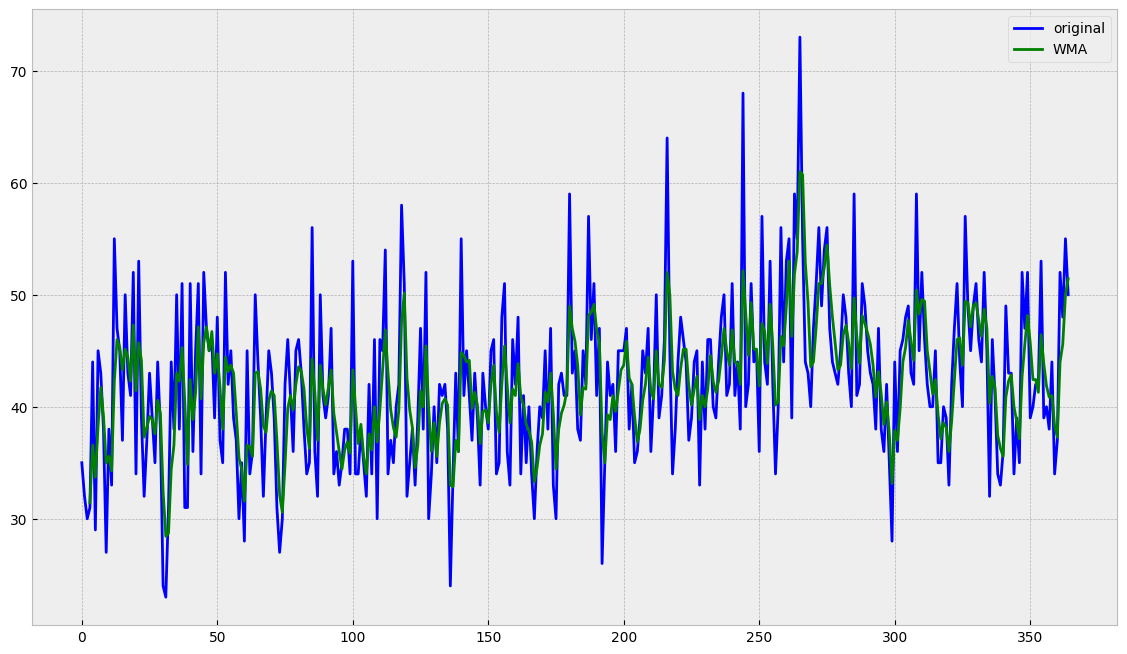

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

In [ ]:
def wma_predict(y_train, y_test, window):
  y_pred = pd.Series([np.NaN for i in range(len(y_train))])
  weights = np.arange(window, 0, -1)
  if not isinstance(weights, np.ndarray):
    weights = np.array(weights)
  if not isinstance(y_train, pd.Series):
    y_train = pd.Series(y_train)
  for i in range(len(y_test)):
    wma = y_train.rolling(window).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    y_pred = pd.concat([y_pred, pd.Series([wma.iloc[-1]])], ignore_index=True)
    y_train = pd.concat([y_train, pd.Series([wma.iloc[-1]])], ignore_index=True)
  return y_pred

In [ ]:
pred = wma_predict(y_train, y_test, 10)

83.39263658847817


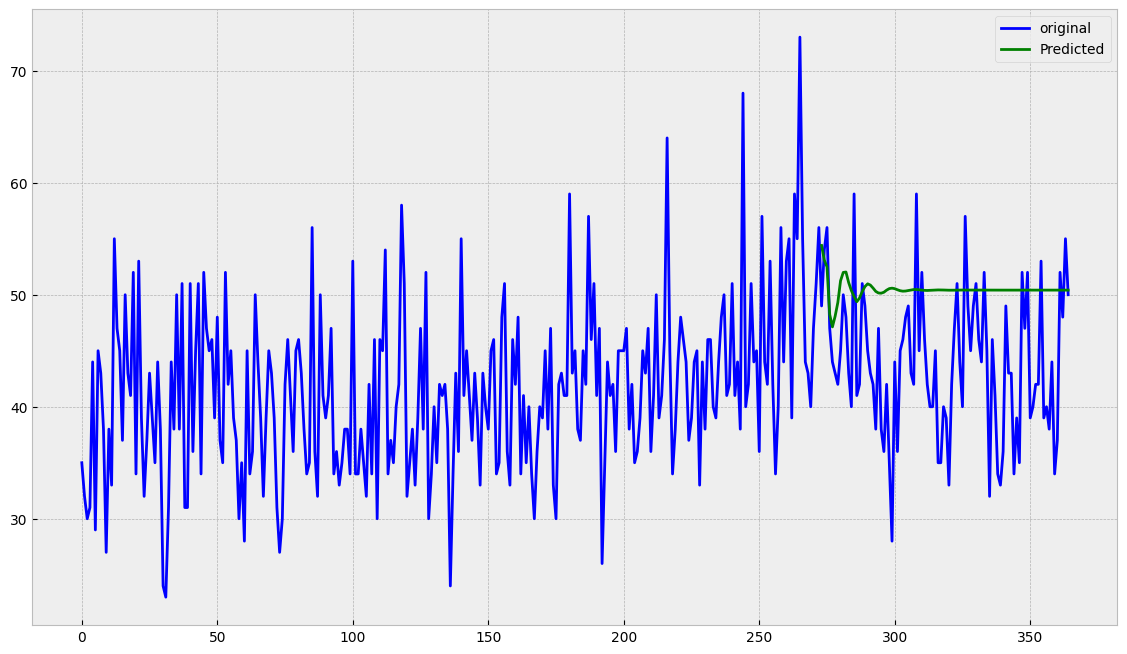

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(female_births["Count"], color='blue',label='original')
    plt.plot(pred, color='green', linewidth='2', label='Predicted')
    plt.legend()
print(mean_squared_error(pred[-len(y_test):], y_test))

In [ ]:
#Экспоненциальное сглаживание
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)

    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)

    return pd.concat([series, pd.Series(predictions)], ignore_index=True), pd.Series(result)

53.050273120343626

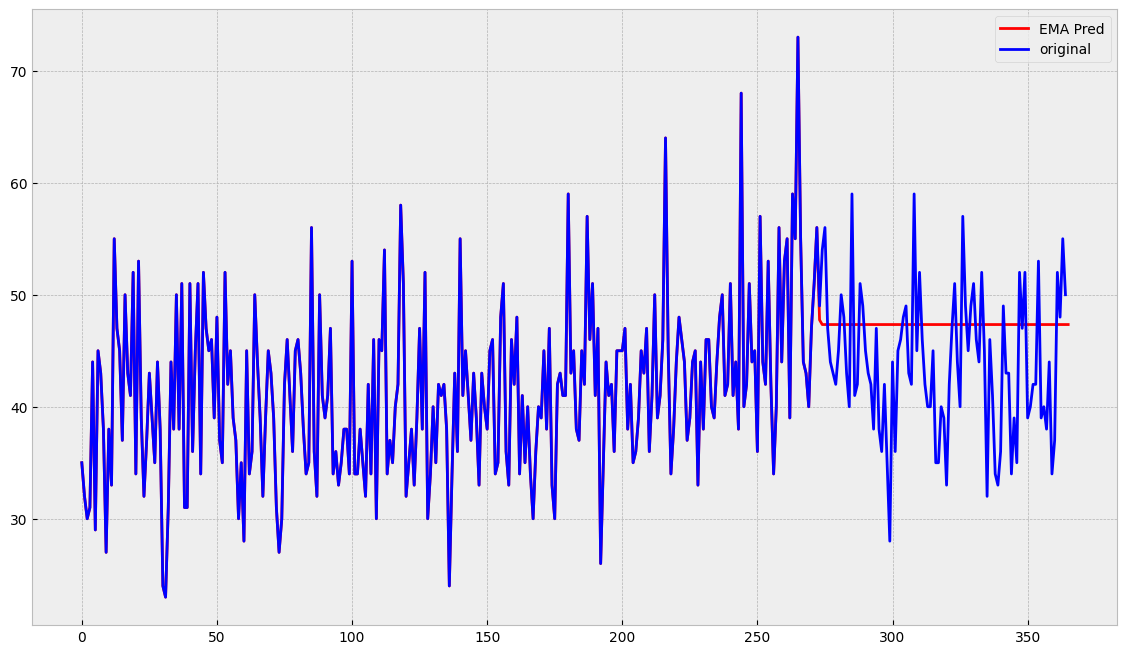

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    ser, _ = exponential_moving_average(y_train, 0.05, len(y_test))
    plt.plot(ser, color='red', linewidth='2', label='EMA Pred')
    plt.plot(female_births["Count"], color='blue', label='original')
    plt.legend()
mean_squared_error(ser[-len(y_test):], y_test)

Так как в ряде "International airline passengers: monthly totals in thousands" имеется наличие тренда и сезонности, наиболее подходящим способом будет Тройное экспоненциальное сглаживание

In [ ]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [ ]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [ ]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0:
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series):
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [ ]:
int(len(airlines_passengers["Count"]) * 0.75)

108

In [ ]:
len(airlines_passengers["Count"])

144

In [ ]:
def plot_tema(alpha, beta, gamma, ser=airlines_passengers["Count"][:108], ser_to_plot=airlines_passengers["Count"], n_preds=36):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()
    print(mean_squared_error(tema[108:], ser_to_plot[108:]))

1785.7849894421554


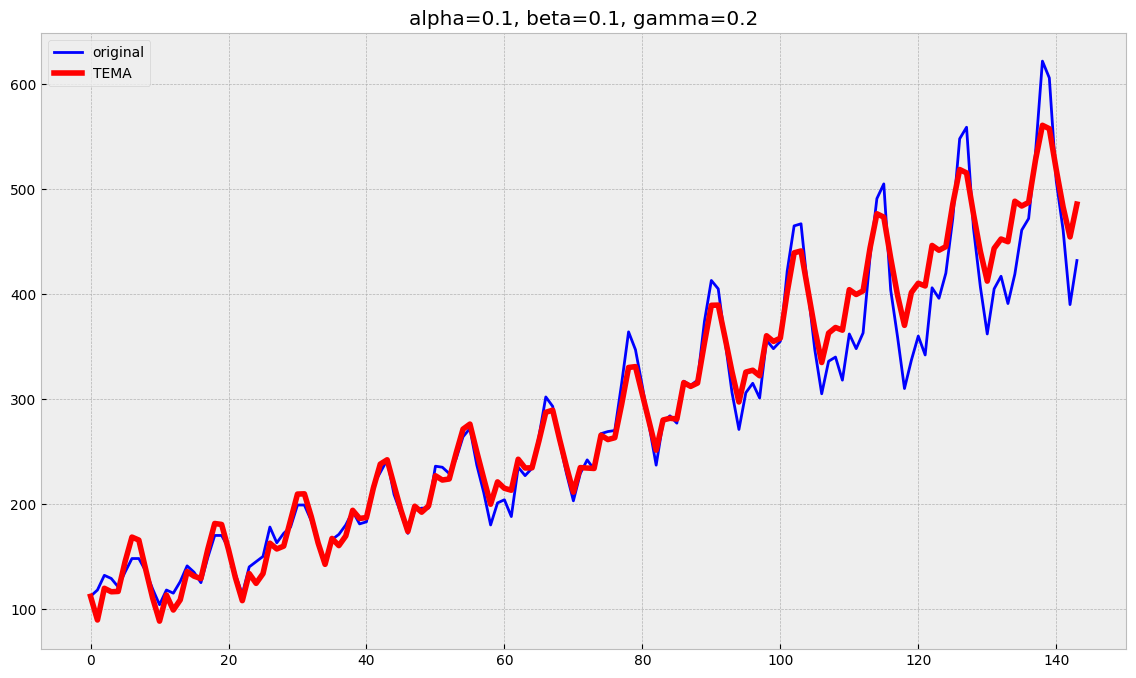

In [ ]:
plot_tema(0.1, 0.1, 0.2)

In [ ]:
train, test, val = airlines_passengers["Count"][:90], airlines_passengers["Count"][90:100], airlines_passengers["Count"][100:]

In [ ]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [ ]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [ ]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 74.47240980751876
        x: [ 2.112e-01  3.190e-02  1.000e+00]
      nit: 23
      jac: [ 4.405e-05  6.821e-05 -1.116e+02]
     nfev: 140
     njev: 35
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


662.6747137212828


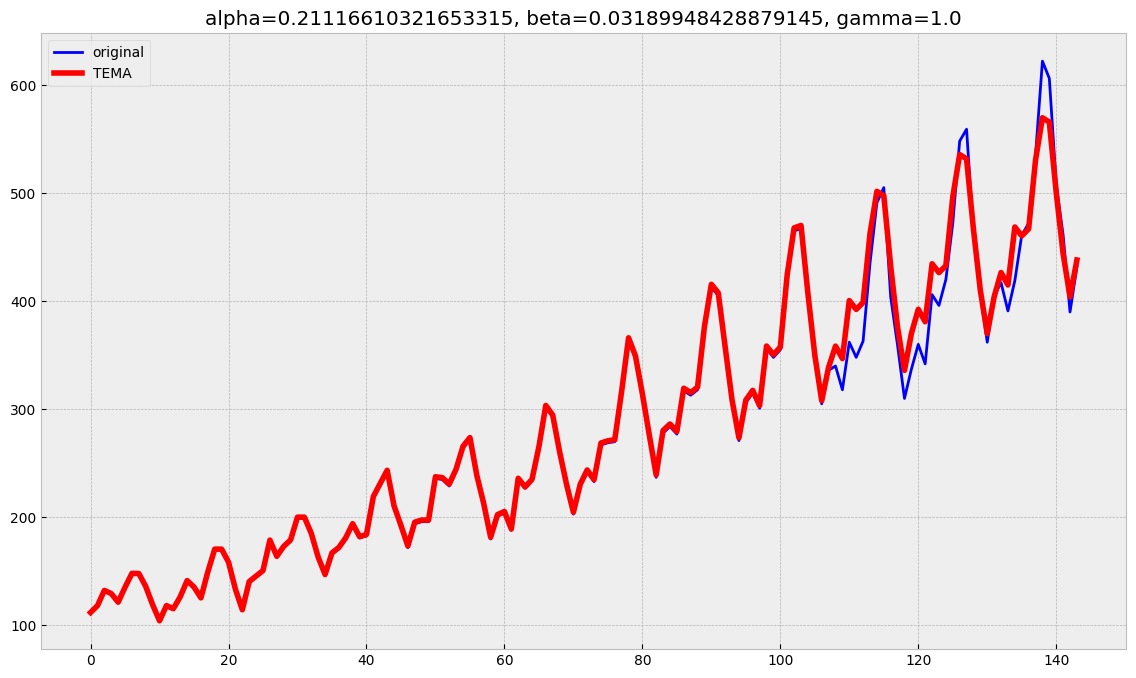

In [ ]:
plot_tema(alpha_opt, beta_opt, gamma_opt)